<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Mask_Covid_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d andrewmvd/face-mask-detection
    !unzip -qq face-mask-detection.zip
    !rm face-mask-detection.zip

     |████████████████████████████████| 204kB 12.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
 95% 377M/398M [00:02<00:00, 111MB/s]
100% 398M/398M [00:02<00:00, 145MB/s]


In [2]:
from torch_snippets import *
from torch_snippets import show
from PIL import Image
from sklearn.utils import shuffle
import albumentations as A
import matplotlib

[04/21/21 01:34:53] WARNING  Not importing Lightning Report      ]8;id=1618968893.7016397-987739;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

[04/21/21 01:34:54] WARNING  sklearn is not found. Skipping relevant  ]8;id=1618968894.241319-508565;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

In [5]:
!python xml_to_csv.py -i /content/annotations -o /content/df.csv -l /content/

Successfully converted xml to csv.
Generate `/content/label_map.pbtxt`


In [67]:
df = pd.read_csv('/content/df.csv')
df.head(20)

filename  width  height         class  xmin  ymin  xmax  ymax
0   maksssksksss793.png    301     400     with_mask   134   147   241   275
1   maksssksksss637.png    400     226     with_mask    37    36    55    54
2   maksssksksss637.png    400     226     with_mask   162    24   192    54
3   maksssksksss637.png    400     226     with_mask   176   109   202   127
4   maksssksksss637.png    400     226     with_mask   261    36   287    63
5   maksssksksss637.png    400     226     with_mask   312    33   329    45
6   maksssksksss637.png    400     226     with_mask   357    27   371    42
7    maksssksksss56.png    400     267     with_mask   191   105   258   183
8    maksssksksss61.png    400     273     with_mask     3   151    51   234
9    maksssksksss61.png    400     273  without_mask   162     9   178    27
10   maksssksksss61.png    400     273     with_mask   117     7   141    26
11   maksssksksss61.png    400     273     with_mask    11     1    33    12
12   maksssksksss61.png    400     273     with_mask    93    37   114    59
13   maksssksksss61.png    400     273     with_mask   125    37   153    65
14   maksssksksss61.png    400     273  without_mask   228    48   244    67
15   maksssksksss61.png    400     273  without_mask   209    61   233    84
16   maksssksksss61.png    400     273     with_mask   264    27   287    53
17   maksssksksss61.png    400     273     with_mask   322    43   340    65
18   maksssksksss61.png    400     273     with_mask   295   117   328   146
19   maksssksksss61.png    400     273     with_mask   361    86   386   109

In [68]:
label2target = {l:t+1 for t,l in enumerate(df['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [69]:
label2target

{'background': 0,
 'mask_weared_incorrect': 3,
 'with_mask': 1,
 'without_mask': 2}

In [70]:
target2label

{0: 'background',
 1: 'with_mask',
 2: 'without_mask',
 3: 'mask_weared_incorrect'}

In [71]:
path = '/content/images/'

In [72]:
df

filename  width  height  ... ymin  xmax  ymax
0     maksssksksss793.png    301     400  ...  147   241   275
1     maksssksksss637.png    400     226  ...   36    55    54
2     maksssksksss637.png    400     226  ...   24   192    54
3     maksssksksss637.png    400     226  ...  109   202   127
4     maksssksksss637.png    400     226  ...   36   287    63
...                   ...    ...     ...  ...  ...   ...   ...
4067  maksssksksss807.png    400     267  ...   28   184    49
4068  maksssksksss807.png    400     267  ...   34   230    58
4069  maksssksksss807.png    400     267  ...   59   259    70
4070  maksssksksss807.png    400     267  ...   37   296    62
4071  maksssksksss807.png    400     267  ...   22   394    44

[4072 rows x 8 columns]

In [73]:
df['class_id'] = df['class'].apply(lambda x: label2target[x])

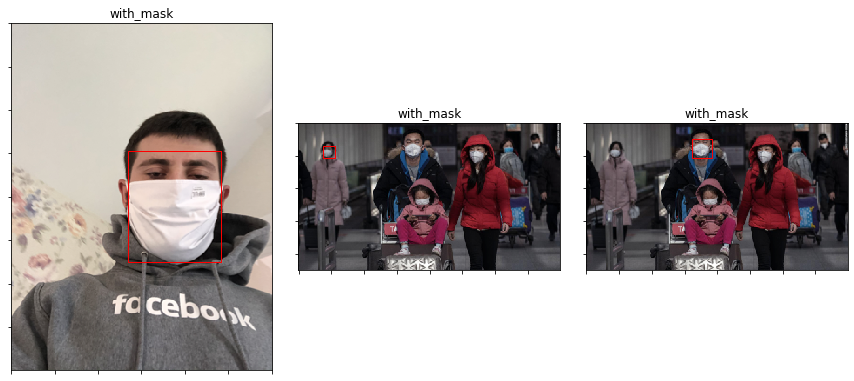

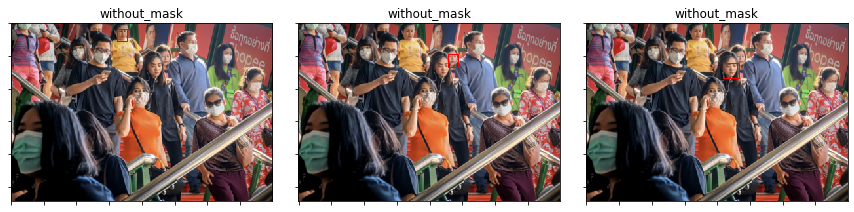

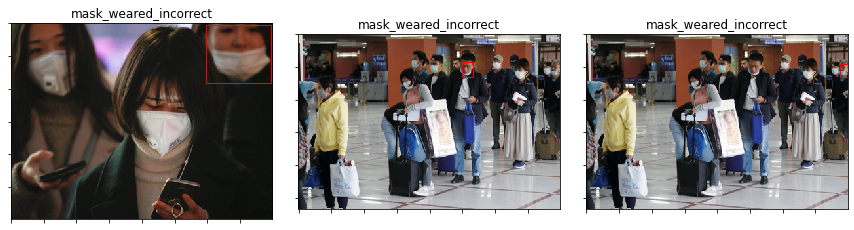

In [75]:
def plot_example(idx_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(3):
        image_id = df.loc[idx_list[i], 'filename']
        dim0 = df.loc[idx_list[i], 'width']
        dim1 = df.loc[idx_list[i], 'height']
        img = Image.open('/content/images/'+image_id)
        axs[i].imshow(img,cmap = plt.cm.gray, interpolation ='nearest')
        axs[i].set_title(df.loc[idx_list[i], 'class'])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if df.loc[idx_list[i], 'class'] != 'No finding':
            bbox = [(df.loc[idx_list[i], 'xmin']),
                    (df.loc[idx_list[i], 'ymin']),
                    (df.loc[idx_list[i], 'xmax']),
                    (df.loc[idx_list[i], 'ymax'])]
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                              bbox[2]-bbox[0],
                                              bbox[3]-bbox[1],
                                              ec='r', fc='none', lw=1.)
            axs[i].add_patch(p)
            
for num in range(1, 4):
    idx_list = df[df['class_id']==num][0:3].index.values
    plot_example(idx_list)

In [76]:
def update_bboxes(df):
    
    df['xmin'] = ((df['xmin'] / df['width'])).astype('float')
    df['ymin'] = ((df['ymin'] / df['height'])).astype('float')
    df['xmax'] = ((df['xmax'] / df['width'])).astype('float')
    df['ymax'] = ((df['ymax'] / df['height'])).astype('float')
    
    return df.reset_index(drop=True)

In [77]:
df = update_bboxes(df)
df

filename  width  height  ...      xmax      ymax  class_id
0     maksssksksss793.png    301     400  ...  0.800664  0.687500         1
1     maksssksksss637.png    400     226  ...  0.137500  0.238938         1
2     maksssksksss637.png    400     226  ...  0.480000  0.238938         1
3     maksssksksss637.png    400     226  ...  0.505000  0.561947         1
4     maksssksksss637.png    400     226  ...  0.717500  0.278761         1
...                   ...    ...     ...  ...       ...       ...       ...
4067  maksssksksss807.png    400     267  ...  0.460000  0.183521         1
4068  maksssksksss807.png    400     267  ...  0.575000  0.217228         1
4069  maksssksksss807.png    400     267  ...  0.647500  0.262172         3
4070  maksssksksss807.png    400     267  ...  0.740000  0.232210         1
4071  maksssksksss807.png    400     267  ...  0.985000  0.164794         1

[4072 rows x 9 columns]

In [78]:
def preprocess_image(img):
    img = torch.tensor(img/255).permute(2,0,1)
    return img.to(device).float()

In [79]:
from torch_snippets import *
from PIL import Image

class covidData(torch.utils.data.Dataset):
  def __init__(self, df, image_dir='/content/images/', transforms=None):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'*.png')
    self.df = df
    self.image_infos = df.filename.unique()
    self.transforms = transforms

  def __getitem__(self, ix):
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data = df[df['filename'] == image_id]
    data = data.reset_index(drop=True)

    if data.loc[0, "class_id"] == 0:
        data = data.loc[[0], :]
    boxes = data[['xmin','ymin', 'xmax', 'ymax']].values

    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    labels = data['class_id'].values
    boxes[:,[0,2]] *= 300
    boxes[:,[1,3]] *= 300

    boxes = boxes.astype(np.uint32).tolist()
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.tensor(labels, dtype=torch.int64)
    target["image_id"] = torch.tensor([ix])
    target['area'] = torch.tensor(area, dtype=torch.float32)
    target['iscrowd'] = torch.zeros(labels.shape[0], dtype=torch.int64)

    if self.transforms:
        sample = {
        'image': image,
        'bboxes': target['boxes'],
        'labels': labels}
        
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])

    if target["boxes"].shape[0] == 0:
        # Albumentation cuts the target (class 14, 1x1px in the corner)
        target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 300.0, 300.0]]))
        target["area"] = torch.tensor([1.0], dtype=torch.float32)
        target["labels"] = torch.tensor([0], dtype=torch.int64)

    
    img = preprocess_image(image)
    return img, target

  def collate_fn(self, batch):
      return tuple(zip(*batch))
    
  def __len__(self):
      return len(self.image_infos)

In [80]:
train_transform = A.Compose(
    [   A.Resize(300,300),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

val_transform = A.Compose(
    [   A.Resize(300,300),
        #A.CenterCrop(height=224, width=224),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [81]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.filename.unique(), test_size=0.7, random_state=88)
trn_df, val_df = df[df['filename'].isin(trn_ids)], df[df['filename'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = covidData(trn_df, transforms = train_transform)
test_ds = covidData(val_df, transforms = val_transform)
                          
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [82]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [83]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [108]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=0.0005)
n_epochs = 10
log = Report(n_epochs)

In [109]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 2.000	trn_loss: 0.364	trn_loc_loss: 0.136	trn_regr_loss: 0.206	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.012	val_loss: 0.378	val_loc_loss: 0.128	val_regr_loss: 0.208	val_objectness_loss: 0.024	val_rpn_box_reg_loss: 0.018	(231.52s - 926.08s remaining)
EPOCH: 4.000	trn_loss: 0.249	trn_loc_loss: 0.080	trn_regr_loss: 0.157	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.009	val_loss: 0.388	val_loc_loss: 0.125	val_regr_loss: 0.202	val_objectness_loss: 0.045	val_rpn_box_reg_loss: 0.017	(460.94s - 691.40s remaining)
EPOCH: 6.000	trn_loss: 0.209	trn_loc_loss: 0.067	trn_regr_loss: 0.131	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.007	val_loss: 0.381	val_loc_loss: 0.140	val_regr_loss: 0.172	val_objectness_loss: 0.053	val_rpn_box_reg_loss: 0.016	(690.99s - 460.66s remaining)
EPOCH: 8.000	trn_loss: 0.181	trn_loc_loss: 0.057	trn_regr_loss: 0.118	trn_objectness_loss: 0.001	trn_rpn_box_reg_loss: 0.006	val_loss: 0.424	val_loc_loss: 0.152	val_regr_loss: 0.194	val_objectness_lo

100%|██████████| 111/111 [00:00<00:00, 1778.12it/s]


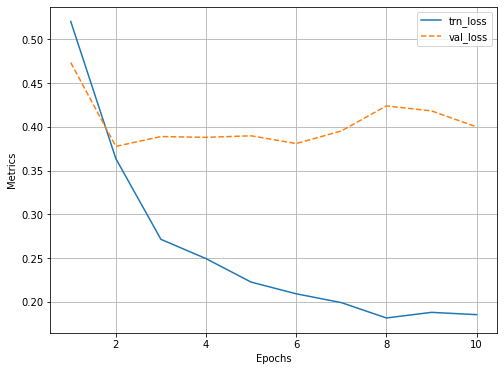

In [110]:
log.plot_epochs(['trn_loss','val_loss'])

In [111]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint32)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


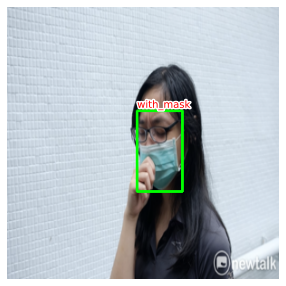

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


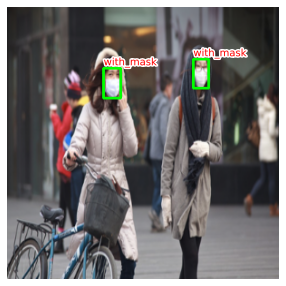

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


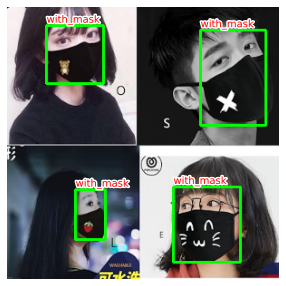

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


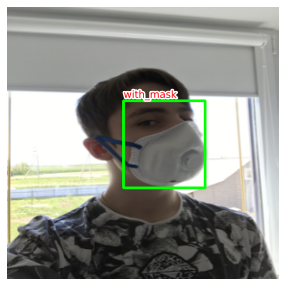

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


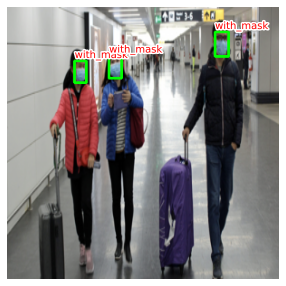

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


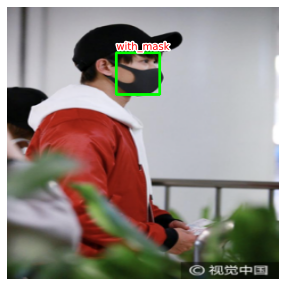

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


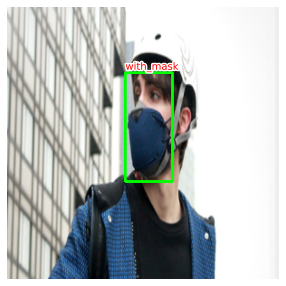

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


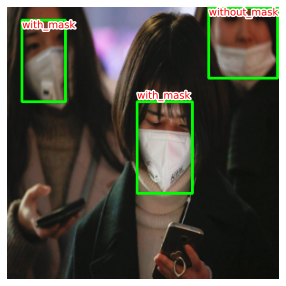

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


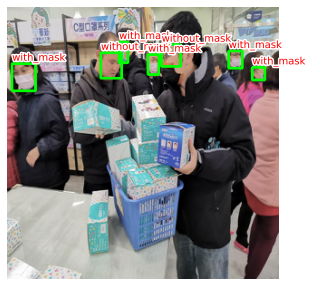

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


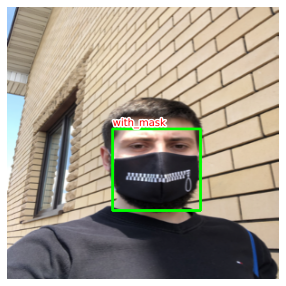

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


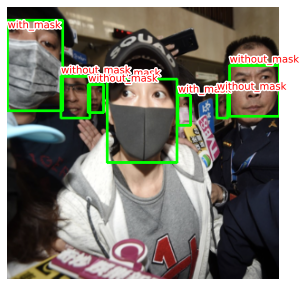

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


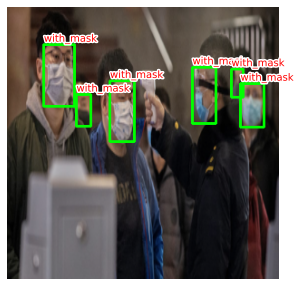

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


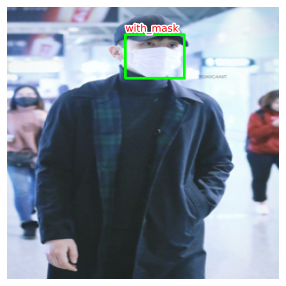

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


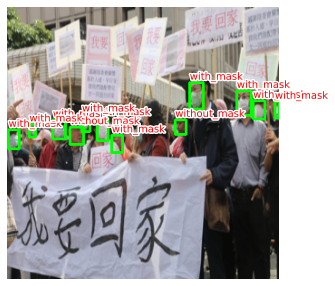

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


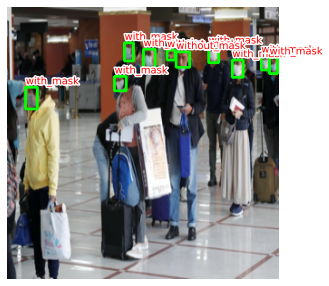

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


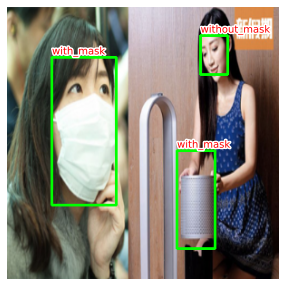

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


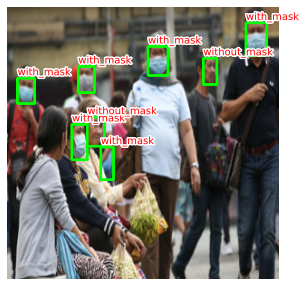

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


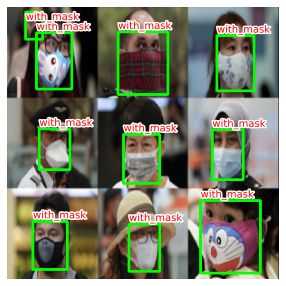

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


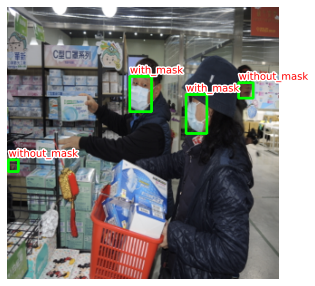

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


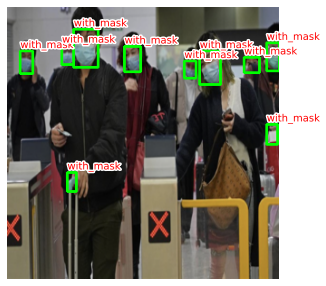

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


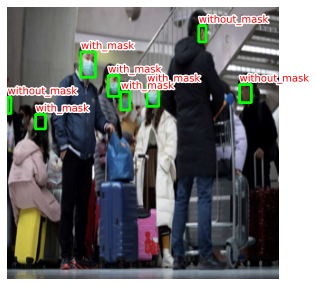

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


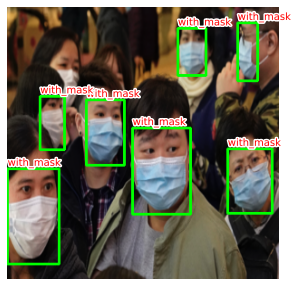

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


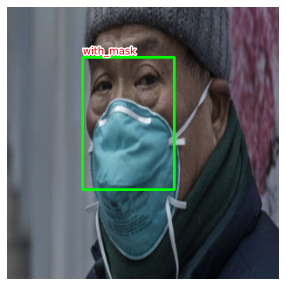

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


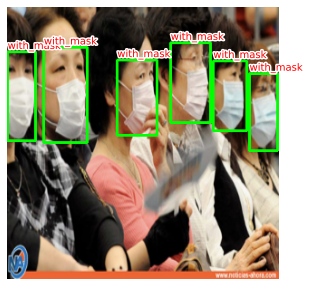

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


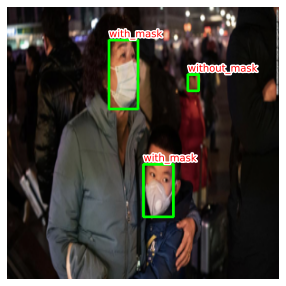

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


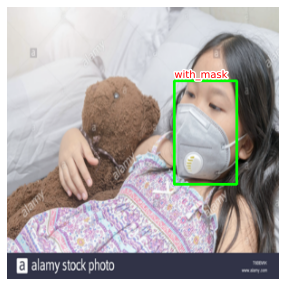

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


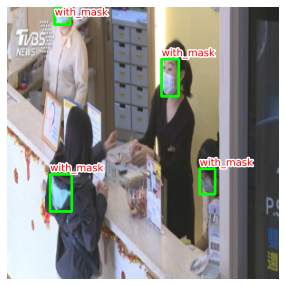

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


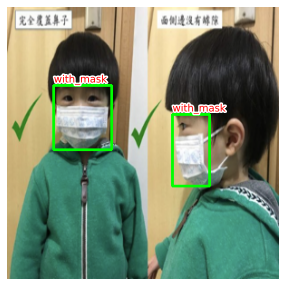

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


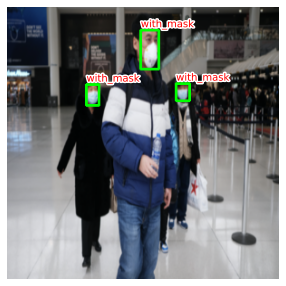

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


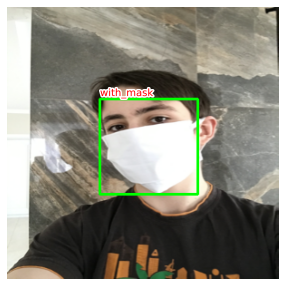

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


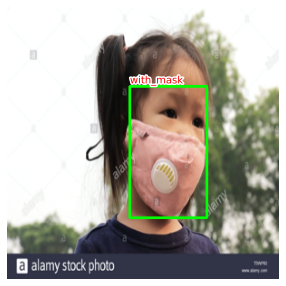

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


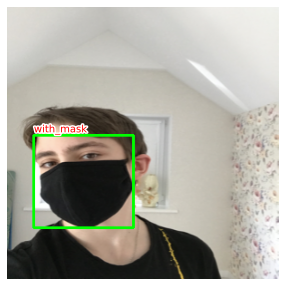

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


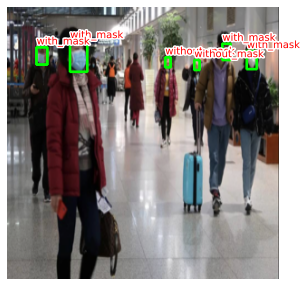

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


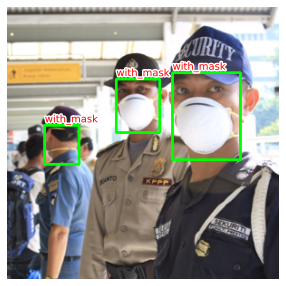

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


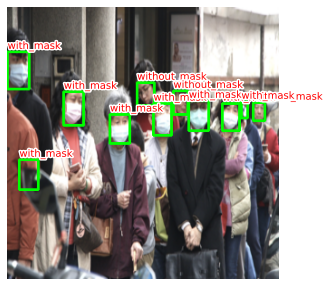

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


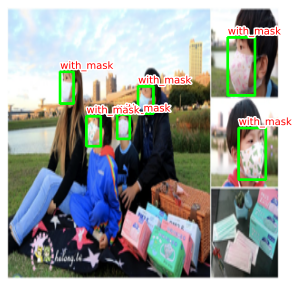

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


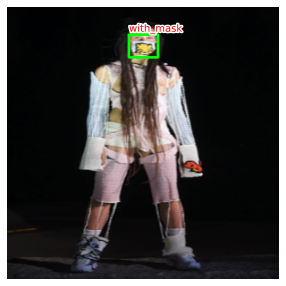

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


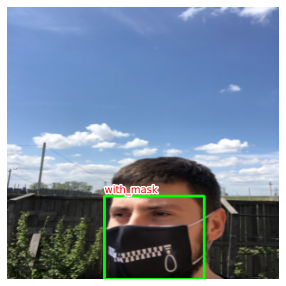

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


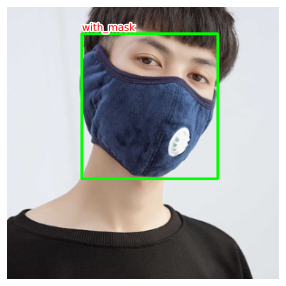

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


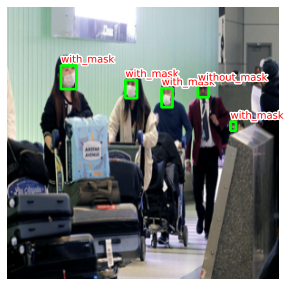

In [112]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==10: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)